# Demo with one common and one rare word

In [1]:
from huggingface_hub import login
from openai import OpenAI
import os
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
import matplotlib.pyplot as plt

c:\Users\zulfi\Desktop\Human AI Interaction\Graded Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
os.environ["NEBIUS_API_KEY"] = "v1.CmMKHHN0YXRpY2tleS1lMDByNG13OHJlOTEwYXhtZjcSIXNlcnZpY2VhY2NvdW50LWUwMHZ2ZW53eDUwMDM1NTU1NjIMCOeCosgGEPu9g74COgsI54W6kwcQwMLuSkACWgNlMDA.AAAAAAAAAAF-s3IVuPd-6SwZfzos0vgqlAlUZtfge6Kj5JAVVepABWajqetR76LusvMMN1mo0E5Y5TbLdhzBkjxNaiMXxrQM"

In [3]:
model_name = "meta-llama/Llama-3.3-70B-Instruct"

## Simple Chain

In [4]:
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.getenv("NEBIUS_API_KEY")
)

In [9]:
def ask(messages):
    result = nebius_client.chat.completions.create(
        model=model_name,
        messages=messages,
        max_tokens=120,
        temperature=0.7,
    )
    return result.choices[0].message.content.strip()


In [54]:
desc_msg = [
            {"role": "user",
             "content": f"Describe this word in detail with 3 sentences WITHOUT naming or directly mentioning it: mouse."}
        ]
description = ask(desc_msg)
print(description)

ChatCompletion(id='chatcmpl-b1658089fe31468a8aad8feeeebeec23', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="This small, nimble creature is a common household pest that is often found scurrying across floors and countertops in search of food and shelter. It has a distinctive pointed snout, large ears, and a long, thin tail that it uses for balance and communication, and is typically gray or brown in color. In many cultures, this tiny rodent is viewed as a nuisance, but it is also a popular and endearing character in children's stories, cartoons, and other forms of media, often depicted as clever and resourceful.", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None)], created=1763506685, model='meta-llama/Llama-3.3-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=109, pro

In [13]:
def run_chain(initial_word, steps=8):
    word = initial_word
    chain = [word]
    chain_desc = []

    for _ in range(steps):
        desc_msg = [
            {"role": "user",
             "content": f"Describe this word in detail with 3 sentences WITHOUT naming or directly mentioning it: {word}."}
        ]
        description = ask(desc_msg)
        chain_desc.append(description)

        guess_msg = [
            {"role": "user",
             "content": f"Based on this description, guess the word: {description}. Reply with your guessed word only."}
        ]
        guessed_word = ask(guess_msg).strip()

        chain.append(guessed_word)
        word = guessed_word

    return chain, chain_desc


### Problem

We are treating the guess and pass as 2 different agents. Need to implement short term memory thing. Should we use some agent style approach? For example, create an agent each time using AutoGen or some other framework, make it save the guess word in its memory, and describe it in the next step. Should also think about logic for the 1st and the last agent (considering that there will be many agents).

We can Use Chat History by Langchain (check if new versions still have it), for each agent in the chain, we are gonna keep the description they heard and their guess in the chat history - only then prompt to generate a new description. This can potentially solve the problem.

In [ ]:
common_word = "apple"
rare_word = "dates (fruit)" # need to find a way to handle such exceptions (different words with the same spelling)

common_chain, common_chain_desc = run_chain(common_word)
rare_chain, rare_chain_desc = run_chain(rare_word)

In [27]:
print("The current model:", model_name)

for a, b, c in zip(common_chain, common_chain_desc, range(len(common_chain))):
    print(f"\n Chain number: {c} \n The word: {a} \n The description is: {b}")


for d, e, f in zip(rare_chain, rare_chain_desc, range(len(rare_chain))):
    print(f"\n Chain number: {f} \n The word: {d} \n The description is: {e}")

The current model: meta-llama/Llama-3.3-70B-Instruct

 Chain number: 0 
 The word: apple 
 The description is: This popular fruit is often red, but can also be found in a variety of other colors, including green, yellow, and sometimes a combination of these hues. It is typically round or oval in shape, with a thin skin that covers a crunchy and juicy interior, containing seeds in the center. The taste of this fruit is sweet and slightly tart, making it a favorite snack for many people around the world, and it is also commonly used in a variety of culinary dishes and products.

 Chain number: 1 
 The word: Apple 
 The description is: This popular fruit is often red, but can also be found in shades of green, yellow, and sometimes a combination of these colors, with a distinctive shape that is typically rounded and slightly elongated. The skin of this fruit is thin and edible, covering a crunchy and juicy interior that is sweet and slightly tart, making it a favorite snack for people of a

In [15]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer("all-MiniLM-L6-v2")

def similarity_curve(original_word, chain):
    orig_emb = embedder.encode(original_word, convert_to_tensor=True)
    sims = []
    for w in chain:
        emb = embedder.encode(w, convert_to_tensor=True)
        sims.append(util.cos_sim(orig_emb, emb).item())
    return sims

In [13]:
def evaluation (common_chain, common_word, rare_chain, rare_word):
    # rare_word = "dates"
    common_sims = similarity_curve(common_word, common_chain)
    rare_sims = similarity_curve(rare_word, rare_chain)
    plt.figure(figsize=(8,5))
    plt.plot(common_sims, label=f"Common: {common_word}")
    plt.plot(rare_sims, label=f"Rare: {rare_word}")
    plt.xlabel("Chain Step")
    plt.ylabel("Semantic Similarity to Original")
    plt.title("Semantic Drift: Rare vs. Common Word")
    plt.legend()
    plt.grid(True)
    plt.show()

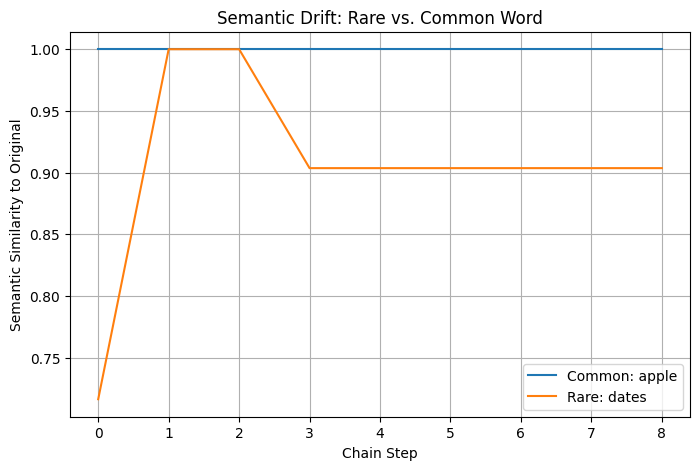

In [62]:
evaluation(common_chain, common_word, rare_chain, rare_word)

Interesting observation, date = fruit and the point of time, but which one is the correct? We need proper evaluation metrics.

## Chain with some memory

In [17]:
chat = ChatOpenAI(
    base_url="https://api.studio.nebius.ai/v1",
    api_key=os.getenv("NEBIUS_API_KEY"),
    model=model_name,
    temperature=0.7
)

In [10]:
def run_chain_with_memory(initial_word, steps=8):
    word = initial_word
    chain = [word]

    desc_msg = [
            {"role": "user",
             "content": f"Describe this word in detail with 2 sentences WITHOUT naming or directly mentioning it: {word}."}
        ]
    description = ask(desc_msg)
    chain_desc = [description]

    for _ in range(steps):
        history = ChatMessageHistory()
        
        history.add_user_message(f"Based on this description, guess the word: {description}. Reply with your guessed word only.")
        guessed_word = chat.invoke(history.messages)
        chain.append(guessed_word.content)       
        history.add_ai_message(guessed_word.content)
        
        word = guessed_word.content
        
        history.add_user_message(f"Describe this word in detail with 2 sentences WITHOUT naming or directly mentioning it: {word}.")
        description = chat.invoke(history.messages)
        chain_desc.append(description.content)       
    

    return chain, chain_desc


In [18]:
common_word = "apple"
rare_word = "dates (fruit)"

common_chain, common_chain_desc = run_chain_with_memory(common_word)
rare_chain, rare_chain_desc = run_chain_with_memory(rare_word)

The current model: meta-llama/Llama-3.3-70B-Instruct

 Chain number: 0 
 The word: apple 
 The description is: This juicy, sweet fruit is often red, green, or sometimes yellow in color, and is typically rounded in shape with a thin skin that's edible. It's a popular and nutritious snack that grows on trees, is rich in fiber and antioxidants, and is widely consumed fresh or used in a variety of culinary and beverage applications.

 Chain number: 1 
 The word: Apple 
 The description is: This popular fruit is a staple in many cuisines around the world, prized for its crunchy texture, sweet flavor, and numerous health benefits, including high levels of fiber, vitamins, and antioxidants that can help boost the immune system and support overall well-being. Growing on deciduous trees in a wide range of varieties, this fruit comes in a variety of colors, including red, green, and yellow, and is often eaten fresh, used in cooking and baking, or pressed into juice and other beverages.

 Chain n

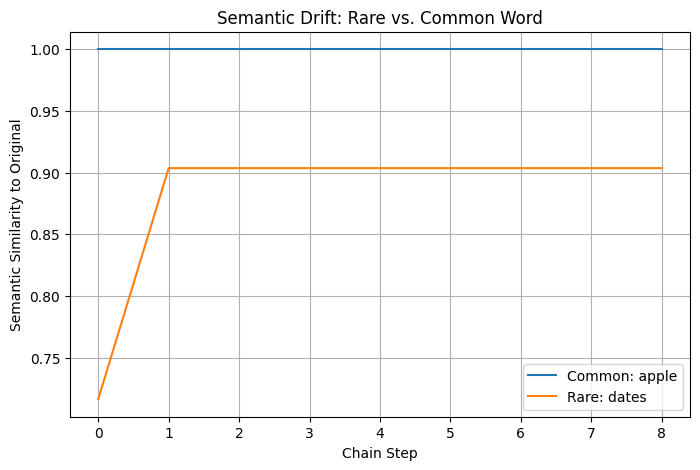

In [20]:
print("The current model:", model_name)

for a, b, c in zip(common_chain, common_chain_desc, range(len(common_chain))):
    print(f"\n Chain number: {c} \n The word: {a} \n The description is: {b}")


for d, e, f in zip(rare_chain, rare_chain_desc, range(len(rare_chain))):
    print(f"\n Chain number: {f} \n The word: {d} \n The description is: {e}")

evaluation(common_chain, common_word, rare_chain, "dates")